# **Promoter Classifier using Nth order Markov Models (PCNMM)**

Here we make a Markov model which given a sequence classifies the it as either having atleast one promoter site or has having no promoter site.

## README

To execute the below code, press the runall button and execute the cells sequentially. This script has, at the end support for sstoring and loading the model as well, and thus will make files and folders on its own with model names. 

The Hyperparameter optimization step section of the code tries to find the order of the markov model that gives the best scores for the validation dataset. This step generally takes long times (Approx 5 mins) to execute.

During Validation, we first use single test train split to validate, and thus get a single ROC and AUC, and then we perform K-Fold validation. We observe that the K-fold validation gives very close ROCs, and thus for the hyperparameter optimization, we only perform single test-train splits to optimize the order.

Necessary conditions for running the code are:
1. A folder named database that includes the negative.fa.gz and positive.fa.gz files must be kept in the same directory as the code.
2. Python version and dependencies needed are mentioned here:
    1. python == 3.10.14
    2. Biopython == 1.79
    3. matplotlib == 3.9.2
    4. numpy == 2.1.1
    5. tqdm == 4.66.4

The code also works if the versions aren't mentioned and are directly installed with "pip install biopython matplotlib numpy tqdm"

### Note:

While making the n-order markov model, we add a padding of n Xs as the start symbol to the sequence. These are then taken as the start n-mer and the rest of the calculations are carried out similar to a sliding window algorithm. The stop symbol as well is just an X symbol. The symbol for both start and stop can be the same as the transition probability from any n-mer to X can only be at the end, and transition probability from X to anything else can only be in the start, by design. 

## INPUTS
* NEG_PATH = path to negative.fa.gz file
* POS_PATH = path to positive.fa.gz file
* K = folds of validation
* ORDER = order of the markov model
* TO_OPTIMIZE_HYPERPARAMETERS = whether hyperparameter optimization is to be done (default to _False_)


In [48]:
# NEG_PATH = "CFG/Project/database/negative.fa.gz"
# POS_PATH = "CFG/Project/database/positive.fa.gz"
NEG_PATH = "./database/negative.fa.gz"
POS_PATH = "./database/positive.fa.gz"
K = 5
ORDER = 2
TO_OPTIMIZE_HYPERPARAMETERS = 0


## Importing the libraries

In [49]:
!pwd

/storage/madhu/deep/CFG/Project


In [50]:
import time
start_time = time.time()
import random
from collections import deque
from tqdm import tqdm
import gzip
from Bio.SeqIO import parse
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pickle
import os


In [51]:
if not os.path.exists('./database'):
    os.makedirs('./database')
if not os.path.exists('./results'):
    os.makedirs('./results')
if not os.path.exists('./models'):
    os.makedirs('./models')

## **Data Analysis and visualization**

## Importing the dataset

In [52]:
# Importing the data
with gzip.open(NEG_PATH, "rt") as handle:
    database_neg = []
    for record in parse(handle, "fasta"):
        # print(type(record))
        database_neg.append(record.seq)
print('Negative Database length = ', len(database_neg)) # 100000
print('Negative seq sample = ', database_neg[0])
# Data shows 100000 positive and negative samples

with gzip.open(POS_PATH, "rt") as handle:
    database_pos = []
    for record in parse(handle, "fasta"):
        # print(type(record))
        database_pos.append(record.seq)
print('Positive Database length = ',len(database_pos))  # 100000
print('Positive seq sample = ', database_pos[0])
# Data shows 100000 positive and negative samples


Negative Database length =  100000
Negative seq sample =  TAAATTAGGCCTTTATTATGTAGTGGGTATTTGTTTATTGGTAGCATATCAATCTATGAGGAGTTAGTGGCTCGTCAA
Positive Database length =  100000
Positive seq sample =  TAGTATATACTTTCGCTGAATTATCACGATCGTCGAGGTAAGGAAGGTAACTACATACGCTCGCATAGGGTAATGTATC


## Visualizing the sequences

Maximum length of the sequence in negative database =  108
Minimum length of the sequence in negative database =  54
Maximum length of the sequence in positive database =  106
Minimum length of the sequence in positive database =  54


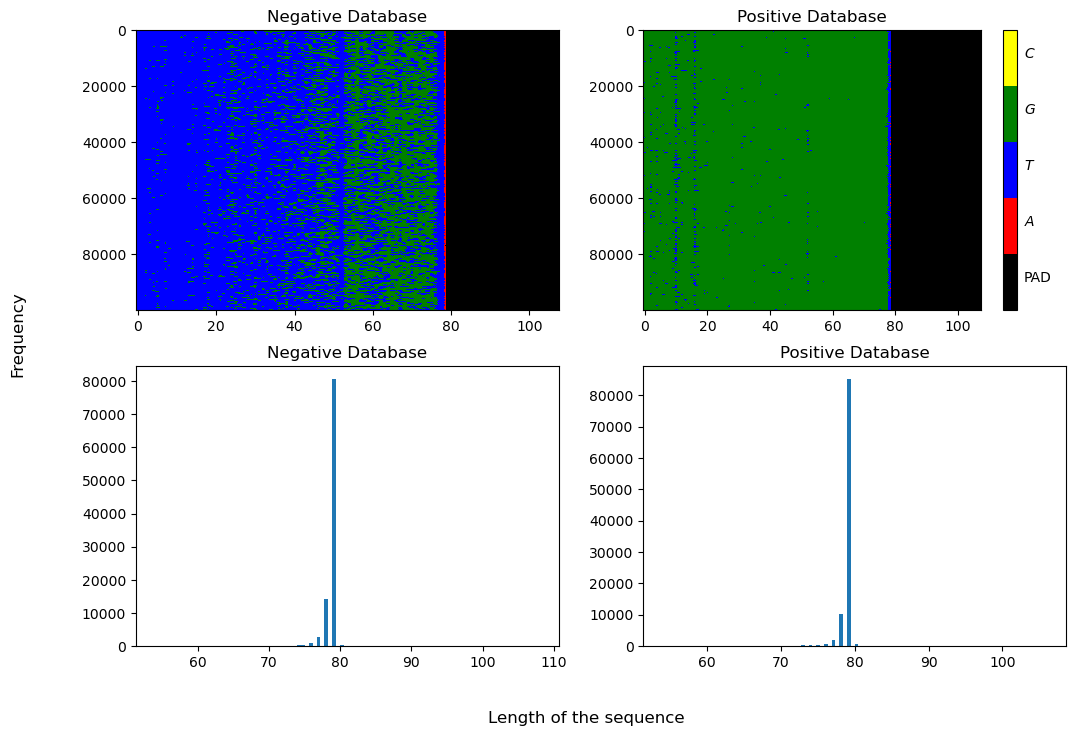

<Figure size 640x480 with 0 Axes>

In [53]:
# Plotting to see if any of the sequences have any patterns in their sequence without alignment
dictionary = ['A','T','G','C']
dict_for_cmap = ['PAD','A','T','G','C']
tokenized_neg = [[dict_for_cmap.index(i) for i in database_neg[j]] for j in range(len(database_neg))]
tokenized_pos = [[dict_for_cmap.index(i) for i in database_pos[j]] for j in range(len(database_pos))]

# Padding the sequences for visualization
lens_n = [len(j) for j in tokenized_neg]
max_n = max(lens_n)
min_n = min(lens_n)

lens_p = [len(j) for j in tokenized_pos]
max_p = max(lens_p)
min_p = min(lens_p)

print('Maximum length of the sequence in negative database = ', max_n)
print('Minimum length of the sequence in negative database = ', min_n)
tokenized_neg = [i + [0]*(max(max_n,max_p)-len(i)) for i in tokenized_neg]

print('Maximum length of the sequence in positive database = ', max_p)
print('Minimum length of the sequence in positive database = ', min_p)
tokenized_pos = [i + [0]*(max(max_n,max_p)-len(i)) for i in tokenized_pos]

cmap = mpl.colors.ListedColormap(['black','red','blue','green','yellow'])
# norm = mpl.colors.BoundaryNorm([0,1,2,3], cmap.N)
# Plotting the tokenized sequences
fig = plt.figure(figsize=(12,8))
ax = plt.subplot(2,2,1)
ax.imshow(tokenized_neg, aspect='auto',cmap=cmap)
ax.set_title('Negative Database')
ax = plt.subplot(2,2,2)
plot = ax.imshow(tokenized_pos, aspect='auto',cmap=cmap)
cbar = fig.colorbar(plot)

cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(['PAD','$A$','$T$','$G$','$C$']):
    cbar.ax.text(1.5, 2*(2 * j + 1) / 5.0, lab)
cbar.ax.get_yaxis().labelpad = 15
# cbar.ax.set_ylabel('# of contacts', rotation=270)
# cbar.ax.set_yticklabels(dict_for_cmap)
ax.set_title('Positive Database')

ax = plt.subplot(2,2,3)
ax.hist(lens_n, bins=100)
ax.set_title('Negative Database')
ax = plt.subplot(2,2,4)
ax.hist(lens_p, bins=100)
ax.set_title('Positive Database')
fig.supxlabel('Length of the sequence')
fig.supylabel('Frequency')
plt.show()
plt.tight_layout()



## Visualizing the frequencies of residues

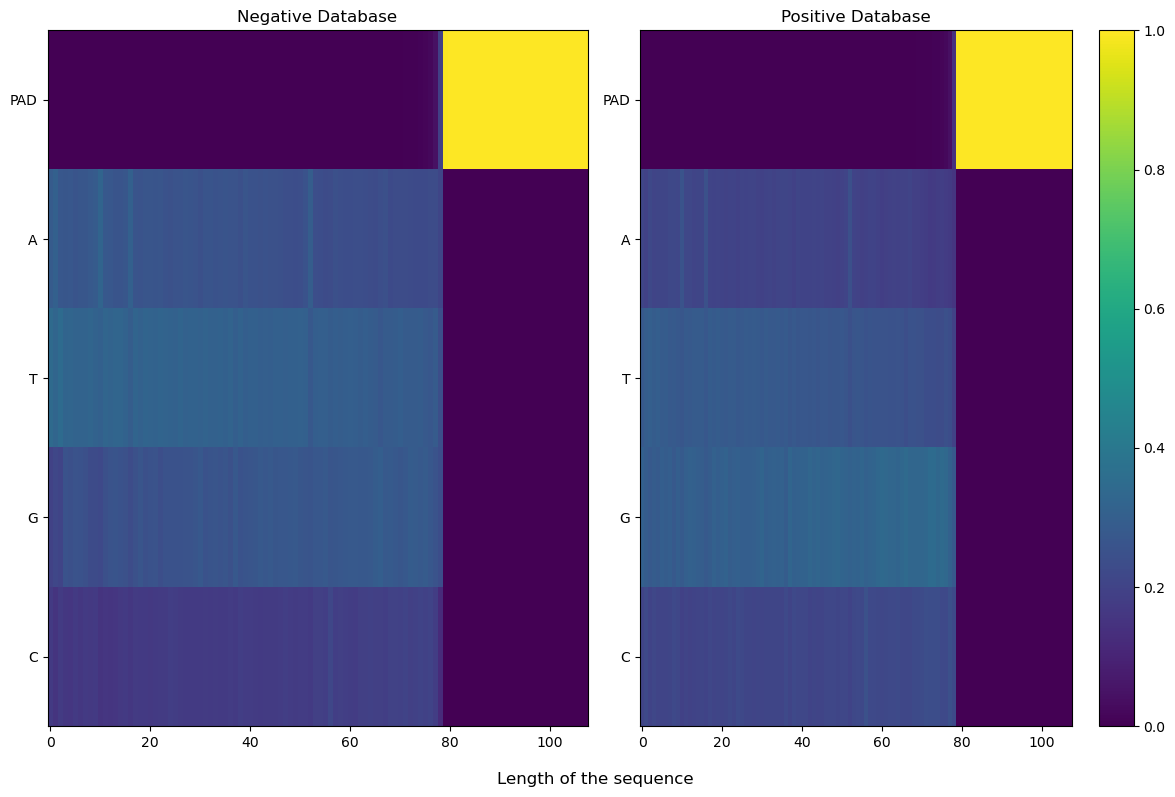

In [54]:
# Visualizing the concensus sequence for + and -
def get_consensus(tokenized):
    concensus = np.zeros((5,max(max_n,max_p)))
    for ele in tokenized:
        for i in range(len(ele)):
            concensus[ele[i]][i]+=1
    concensus = concensus/len(tokenized)
    return concensus

consensus_neg = get_consensus(tokenized_neg)
consensus_pos = get_consensus(tokenized_pos)

# NOTE: Uncomment these the get the image in matrix form
# print(consensus_neg)
# print(consensus_pos)

fig=plt.figure(figsize=(12,8))
ax = plt.subplot(1,2,1)
ax.imshow(consensus_neg, aspect='auto')
ax.set_yticks([0,1,2,3,4],dict_for_cmap)
ax.set_title('Negative Database')
ax = plt.subplot(1,2,2)
plot = ax.imshow(consensus_pos, aspect='auto')
ax.set_yticks([0,1,2,3,4],dict_for_cmap)
ax.set_title('Positive Database')
cbar = fig.colorbar(plot)
fig.supxlabel('Length of the sequence')
# fig.supylabel('Frequency')
# cbar.ax.get_yaxis().set_ticks([])
# for j, lab in enumerate(['PAD','$A$','$T$','$G$','$C$']):
#     cbar.ax.text(1.5, 2*(2 * j + 1) / 5.0, lab)
# cbar.ax.get_yaxis().labelpad = 15
plt.tight_layout()


We can see that T is more in Negative database and G is more in Positive database. Indicating that there is a corelation with GC content

The padding is required for most sequences except one or two -> Wont be a problem in markov models anyways, but could be a potential problem for NN

## **Test-Train split**

In [55]:

train_split = 0.8 # 80% of the data is used for training
# Splitting the data into training and testing
train_neg = database_neg[:int(len(database_neg)*train_split)]
test_neg = database_neg[int(len(database_neg)*train_split):]
train_pos = database_pos[:int(len(database_pos)*train_split)]
test_pos = database_pos[int(len(database_pos)*train_split):]

## **Making the model**

In [56]:
# Making the Markov Model

class MarkovModelMaker():
    def __init__(self,n,database,dictionary=['A','T','G','C']):
        '''
        n: order of the model
        database: list of sequences in ATGC format
        dictionary: list of tokens, here ['A','T','G','C']

        output:
        Markov model of order n
        '''
        self.order = n
        self.database = database
        self.tokens= dictionary
        # add the start token
        self.tokens = ['X']+self.tokens
        self.model = np.zeros((5**self.order,5)) # 5**n = no of all sequences includin X. 4 since ATGC and know that X comes when seq ends (Same token as start and end is always distinct so no problem)
    
    def get_index_nmer(self,nmer):
        '''
        nmer: nmer in the form of ATGC
        output:
        index of the nmer in the model
        '''
        index = 0
        for i in range(len(nmer)):
            index += (5**i)*self.tokens.index(nmer[len(nmer)-i-1])
        # print('hola')
        return index
    def get_nmer_index(self,index):
        '''
        index: index of the nmer in the model
        output:
        nmer in the form of ATGC
        '''
        nmer = ''
        for i in range(self.order):
            nmer = self.tokens[index%5]+nmer
            index = index//5
        return nmer
    def normalize_model(self):
        '''
        output:
        Normalized model
        '''
        self.model += (self.model==0.0).astype(int) # To avoid division by zero
        for i in range(self.model.shape[0]):
            self.model[i] = self.model[i]/np.sum(self.model[i])
        
    def make_model(self):
        '''
        output:
        Markov model of order n
        '''
        for seq in self.database:
            seq = ['X']*(self.order) + list(seq) + ['X'] # n starting Xs and 1 ending X
            prev = seq[:self.order]
            # print(prev)
            for i in range(self.order,len(seq)):
                # print('halo')
                self.model[self.get_index_nmer(prev)][self.tokens.index(seq[i])]+=1
                if self.order>0:
                    prev = prev[1:]+[seq[i]]
        self.normalize_model()
    
    def get_probab(self,seq):
        '''
        seq: sequence in ATGC format
        output:
        probability of the sequence
        '''
        seq = ['X']*(self.order) + list(seq) + ['X']
        Log_probab = 0 # Log probability to avoid underflow
        for i in range(self.order,len(seq)):
            if np.log(self.model[self.get_index_nmer(seq[i-self.order:i])][self.tokens.index(seq[i])])<-8:
                print((self.model[self.get_index_nmer(seq[i-self.order:i])][self.tokens.index(seq[i])]))
                print(seq[i-self.order:i],seq[i])
            Log_probab += np.log(self.model[self.get_index_nmer(seq[i-self.order:i])][self.tokens.index(seq[i])])
        return Log_probab
    
    
    def show_model_image(self):
        '''
        output:
        Image of the model
        '''
        fig = plt.figure(figsize=(12,8*(max(self.order-1,1))))
        ax = plt.subplot(1,1,1)
        plot = ax.imshow(self.model, aspect='auto')
        fig.colorbar(plot)
        ax.set_yticks(np.arange(5**self.order),[self.get_nmer_index(i) for i in range(5**self.order)])
        ax.set_xticks(np.arange(5),[self.tokens[i] for i in range(5)])
        plt.tight_layout()
        plt.show()
    
    def generate_seq(self):
        '''
        output:
        Random sequence generated from the model
        '''
        seq=''
        start = 'X'*self.order
        stop = False
        while not stop:
            probab = self.model[self.get_index_nmer(start)]
            token = np.random.choice(np.arange(5),p=probab)
            if self.tokens[token]=='X':
                stop = True
            else:
                seq+=self.tokens[token]
                start = start[1:]+self.tokens[token]
        return seq

    def save_model(self,filename):
        '''
        filename: name of the file to save the model
        output:
        Saves the model in the file
        '''
        model_params = {'order':self.order,'model':self.model,'tokens':self.tokens,'database':self.database}
        with open(filename, 'wb') as handle:
            pickle.dump(model_params, handle)
    
    def load_model(self,filename):
        '''
        filename: name of the file to load the model
        output:
        Loads the model from the file
        '''
        with open(filename,'rb') as handle:
            model_params = pickle.load(handle)
        self.order = model_params['order']
        self.model = model_params['model']
        self.tokens = model_params['tokens']
        self.database = model_params['database']



In [57]:
ORDER=2

In [58]:
mm_neg = MarkovModelMaker(ORDER,train_neg)
mm_pos = MarkovModelMaker(ORDER,train_pos)

In [59]:
mm_neg.make_model()
mm_pos.make_model()

## Visualizing the models

The below images show the probabilities of the next base occuring in the x axis, given previously seen n-mer on the y-axis. Here we have added a pseudo counts of 1 to each cell before calculating the probabilities, thus one can see that rows such as AX (in case of order 2) are all having equal probabilities as these are impossible transitions since X represents stop symbol, which means no base will come after stop. So these cells anyways won't contribute to the model so can be ignored.

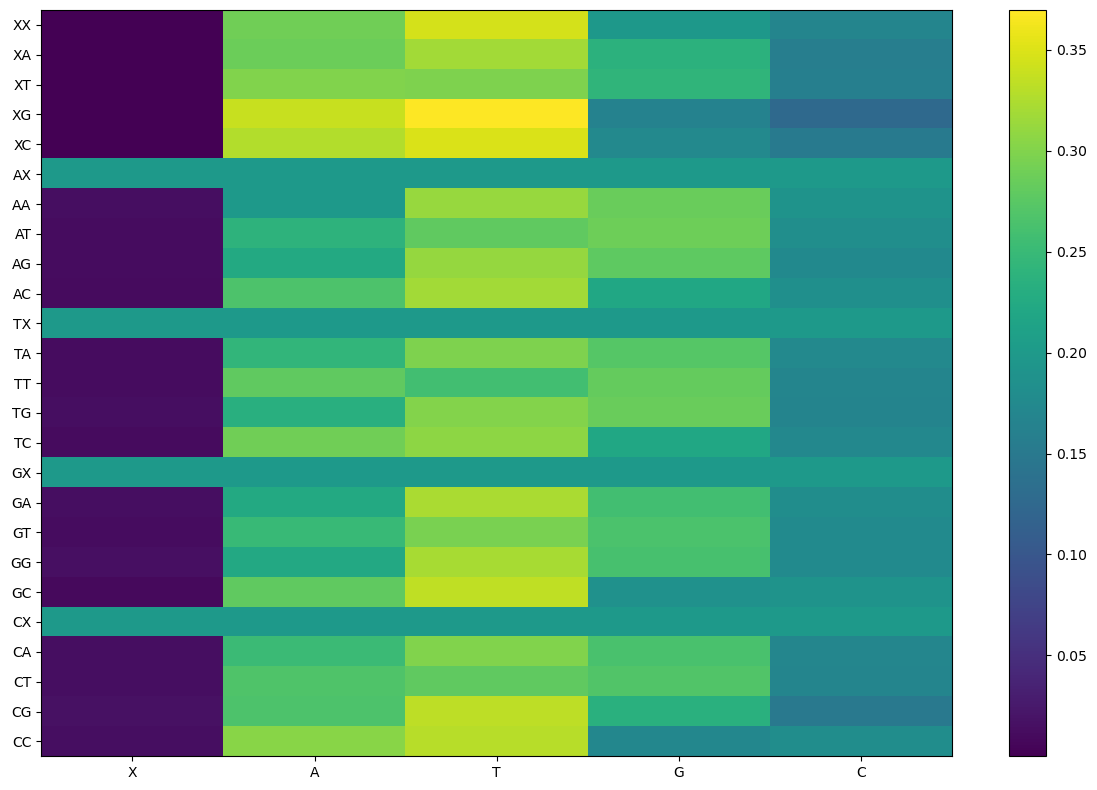

In [60]:
# mm.show_model_image()
mm_neg.show_model_image()

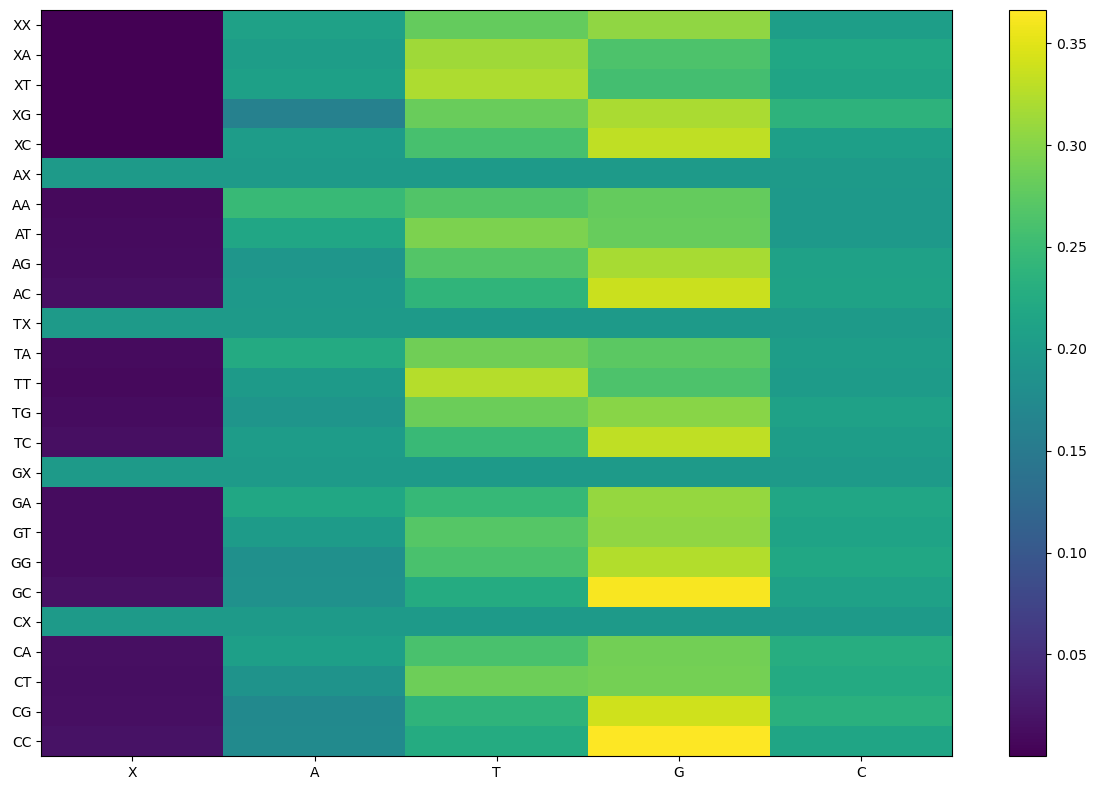

In [61]:
mm_pos.show_model_image()

In [62]:
# mm.get_index_nmer('XA')

## Checking on a small chunk to see how the model performs

In [63]:
for seq in test_neg[:5]:
    print('neg-neg',mm_neg.get_probab(seq))
    print('neg-pos',mm_pos.get_probab(seq))

for seq in test_pos[:5]:
    print('pos-neg',mm_neg.get_probab(seq))
    print('pos-pos',mm_pos.get_probab(seq))

neg-neg -112.5207301188552
neg-pos -115.21382040103182
neg-neg -113.31849371684169
neg-pos -118.69108742699756
neg-neg -112.78742410445065
neg-pos -115.01487519513819
neg-neg -112.21476078908833
neg-pos -114.14681481796077
neg-neg -112.34993649392825
neg-pos -114.38946297248484
pos-neg -119.3771482333632
pos-pos -111.5349622264596
pos-neg -120.31954796905083
pos-pos -114.14901742411548
pos-neg -115.19620117589916
pos-pos -112.03959963079716
pos-neg -116.59354114669236
pos-pos -114.04586068773297
pos-neg -119.0891456399697
pos-pos -112.64008057730675


### Aside- generating sequences and seeing what they look like

In [64]:
mm_neg.generate_seq()


'GTAGTGTAAGAGTTAATGTATTGTATGATAAGG'

In [65]:
mm_pos.generate_seq()

'TTATTGTACGCACGGCTGTTCTCGTAGTCAGTACGGCTAACCTGGGCGTGGAGATCACGGTGTCGCGTATCGGGAGCAATATTGTTAGAGGTGTGAGTGCCAGGCCACCGTGGGCAGATCGGGAAATTGATGTTTTTTGTTCAGCGTACTGCGTGTTCCGGAGGCGAGTGGTTTTGTATCCTTGGAAGCACTGGAATGCGTGTTGGCACGTAAGAAGATGATTGGCGGGCTGAGCCTGCAGTGTGATGCCATTGCAGGTCGGGACTATCAGTATCCGTCGCACTCAGCTTGGTATCGCCTTCCGAGGCTGCTTGTGACGGA'

## **Validating the model**

Validating the model on a single validation set

In [66]:
def check_test_set_scores_only(model_neg=mm_neg,model_pos=mm_pos,database_neg=test_neg,database_pos=test_pos):
    '''
    test_set: list of sequences
    mm_pos: Markov model for positive sequences
    mm_neg: Markov model for negative sequences
    CUTOFF: cutoff value for the probability
    output:
    list of neg and pos scores
    '''
    neg_values=[]
    tp,fp,tn,fn=0,0,0,0
    for seq in database_neg:
        probab_pos = model_pos.get_probab(seq)
        probab_neg = model_neg.get_probab(seq)
        value = probab_pos-probab_neg
        neg_values.append(value)
    pos_values = []
    for seq in database_pos:
        probab_pos = model_pos.get_probab(seq)
        probab_neg = model_neg.get_probab(seq)
        value = probab_pos-probab_neg
        pos_values.append(value)
    return neg_values,pos_values

NVS,PVS = check_test_set_scores_only()
def check_test_set_with_cutoff(cutoff,neg_values=NVS,pos_values=PVS):
    '''
    test_set: list of sequences
    mm_pos: Markov model for positive sequences
    mm_neg: Markov model for negative sequences
    CUTOFF: cutoff value for the probability
    output:
    True if the sequence is classified correctly
    '''
    tp,fp,tn,fn=0,0,0,0
    for value in neg_values:
        if value<cutoff:
            tn+=1
        else:
            fp+=1
    for value in pos_values:
        if value>cutoff:
            tp+=1
        else:
            fn+=1
    return tp,fp,tn,fn


In [75]:

def plot_one_ROC(label='',NVS_roc=NVS,PVS_roc=PVS):
    x=[]
    y=[]
    c=[]
    fig = plt.figure(figsize=(4,4))
    for cutoff in range(100):
        tp,fp,tn,fn = check_test_set_with_cutoff(cutoff=(cutoff/5)-10,neg_values=NVS_roc,pos_values=PVS_roc)
        tpr = tp/(tp+fn)
        fpr = fp/(fp+tn)
        x.append(fpr)
        y.append(tpr)
        c.append((cutoff/5)-10)

    if label=='RETURN_XY':
        return x,y,None
    elif label=='RETURN_XYZ':
        return x,y,c
    elif label!='':
        plt.plot(x,y,label=label)
    else:
        plt.plot(x,y,'r')
    return None,None,None

def plot_one_PRC(label='',NVS_roc=NVS,PVS_roc=PVS):
    x=[]
    y=[]
    c=[]
    fig = plt.figure(figsize=(4,4))
    for cutoff in range(100):
        tp,fp,tn,fn = check_test_set_with_cutoff(cutoff=(cutoff/5)-10,neg_values=NVS_roc,pos_values=PVS_roc)
        p = tp/(tp+fp)
        r = tp/(tp+fn)
        x.append(r)
        y.append(p)
        c.append((cutoff/5)-10)

    if label=='RETURN_XY':
        return x,y,None
    elif label=='RETURN_XYZ':
        return x,y,c
    elif label!='':
        plt.plot(x,y,label=label)
    else:
        plt.plot(x,y,'r')
    return None,None,None


def plot_multiple_ROC(label='',NVS_roc=NVS,PVS_roc=PVS,ax=None,fig=None):
    x=[]
    y=[]
    c=[]
    if ax==None and fig!=None:
        ax = fig.add_subplot(2,1,1)

    for cutoff in range(100):
        tp,fp,tn,fn = check_test_set_with_cutoff(cutoff=(cutoff/5)-10,neg_values=NVS_roc,pos_values=PVS_roc)
        # print(tp,fp,tn,fn)
        tpr = tp/(tp+fn+1) # +1 to avoid division by zero
        fpr = fp/(fp+tn+1) # +1 to avoid division by zero
        x.append(fpr)
        y.append(tpr)
        c.append((cutoff/5)-10)

    if label!='':
        ax.plot(x,y,label=label)
    else:
        ax.plot(x,y,'r')
    return ax

def plot_multiple_PRC(label='',NVS_roc=NVS,PVS_roc=PVS,ax=None,fig=None):
    x=[]
    y=[]
    c=[]
    if ax==None and fig!=None:
        ax = fig.add_subplot(2,1,2)
    for cutoff in range(100):
        tp,fp,tn,fn = check_test_set_with_cutoff(cutoff=(cutoff/5)-10,neg_values=NVS_roc,pos_values=PVS_roc)
        p = tp/(tp+fp+1) # +1 to avoid division by zero
        r = tp/(tp+fn+1) # +1 to avoid division by zero
        x.append(r)
        y.append(p)
        c.append((cutoff/5)-10)

    if label!='':
        ax.plot(x,y,label=label)
    else:
        ax.plot(x,y,'r')
    return ax

def get_PRC(label='',NVS_roc=NVS,PVS_roc=PVS):
    x,y,c = plot_one_PRC(label=label,NVS_roc=NVS_roc,PVS_roc=PVS_roc)
    if label=='RETURN_XY':
        return x,y,c
    elif label=='RETURN_XYZ':
        return x,y,c
    else:
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('PRC')
    return None,None,None
def get_ROC(label='',NVS_roc=NVS,PVS_roc=PVS):
    x,y,c = plot_one_ROC(label=label,NVS_roc=NVS_roc,PVS_roc=PVS_roc)
    if label=='RETURN_XY':
        return x,y,c
    elif label=='RETURN_XYZ':
        return x,y,c
    else:
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC')
    return None,None,None

def calc_AUC(NVS_roc=NVS,PVS_roc=PVS):
    x,y,c = get_ROC(label='RETURN_XY',NVS_roc=NVS_roc,PVS_roc=PVS_roc)
    # print(x)
    # print(y)
    auc = 0
    for i in range(len(x)-1):
        auc+=(y[i]+y[i+1])*(abs(x[i]-x[i+1]))/2
    return auc
    # plt.show()

def get_best_thresh(NVS_roc=NVS,PVS_roc=PVS):
    x,y,c = get_ROC(label='RETURN_XYZ',NVS_roc=NVS_roc,PVS_roc=PVS_roc)
    print('Thresholds considered = ', c)
    best_thresh = 0
    best_diff = 1
    for i in range(len(x)):
        dist = np.sqrt(x[i]**2+(1-y[i])**2)
        # print(dist)
        if dist<best_diff:
            best_diff = dist
            best_thresh = c[i]
    return best_thresh


AUC Of the ROC =  0.9341346249999997
Thresholds considered =  [-10.0, -9.8, -9.6, -9.4, -9.2, -9.0, -8.8, -8.6, -8.4, -8.2, -8.0, -7.8, -7.6, -7.4, -7.2, -7.0, -6.8, -6.6, -6.4, -6.2, -6.0, -5.8, -5.6, -5.4, -5.2, -5.0, -4.8, -4.6, -4.4, -4.2, -4.0, -3.8, -3.5999999999999996, -3.4000000000000004, -3.2, -3.0, -2.8, -2.5999999999999996, -2.4000000000000004, -2.2, -2.0, -1.8000000000000007, -1.5999999999999996, -1.4000000000000004, -1.1999999999999993, -1.0, -0.8000000000000007, -0.5999999999999996, -0.40000000000000036, -0.1999999999999993, 0.0, 0.1999999999999993, 0.40000000000000036, 0.5999999999999996, 0.8000000000000007, 1.0, 1.1999999999999993, 1.4000000000000004, 1.5999999999999996, 1.8000000000000007, 2.0, 2.1999999999999993, 2.4000000000000004, 2.5999999999999996, 2.8000000000000007, 3.0, 3.1999999999999993, 3.4000000000000004, 3.5999999999999996, 3.8000000000000007, 4.0, 4.199999999999999, 4.4, 4.6, 4.800000000000001, 5.0, 5.199999999999999, 5.4, 5.6, 5.800000000000001, 6.0, 6.1

<Figure size 400x400 with 0 Axes>

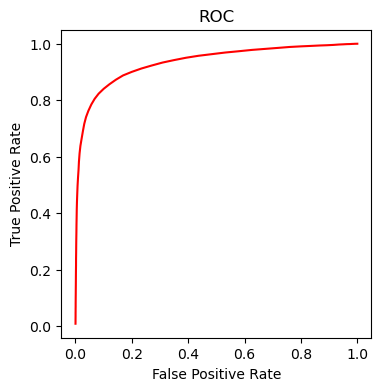

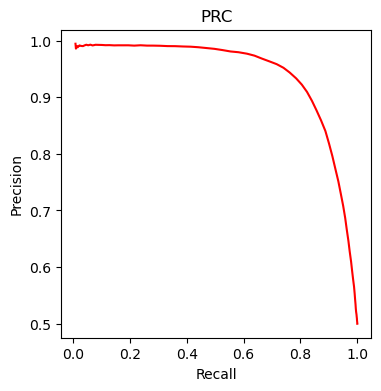

<Figure size 400x400 with 0 Axes>

In [76]:

auc = calc_AUC()
print('AUC Of the ROC = ',auc)
get_ROC()
get_PRC()
print('Best threshold as per the ROC is = ' , get_best_thresh())

## **K FOLD VALIDATION** 

In [84]:
def get_K_sets(full_pos_database=database_pos,full_neg_database=database_neg):
    # Fist we split in K sets:
    pos_database_sets=[]
    neg_database_sets=[]
    deque_pos = deque(full_pos_database)
    deque_neg = deque(full_neg_database)
    sample_pos = random.sample(range(len(full_pos_database)),len(full_pos_database))
    sample_neg = random.sample(range(len(full_neg_database)),len(full_neg_database))
    for i in range(K):
        pos_database_sets.append([deque_pos[j] for j in sample_pos if j%K==i])
        neg_database_sets.append([deque_neg[j] for j in sample_neg if j%K==i])
    return pos_database_sets,neg_database_sets

        
# p,n = get_K_sets()
# K=2
def plot_multiple_ROCs_and_get_avgAUC(full_pos_database=database_pos,full_neg_database=database_neg,order_loc=ORDER):
    fig = plt.figure(figsize=(8,12))
    p,n = get_K_sets(full_pos_database=full_pos_database,full_neg_database=full_neg_database)
    auc=0
    ax_ROC=None
    ax_PRC=None
    fig = plt.figure(figsize=(8,12))
    for i in range(K):
        train_except_i_p = p[:i]+p[i+1:]
        train_pos_subset = []
        for pos in train_except_i_p:
            train_pos_subset+=pos
        train_except_i_n = n[:i]+n[i+1:]
        train_neg_subset = []
        for neg in train_except_i_n:
            train_neg_subset+=neg
        val_pos = p[i] 
        val_neg = n[i]
        mm_neg_val = MarkovModelMaker(order_loc,train_neg_subset)
        mm_pos_val = MarkovModelMaker(order_loc,train_pos_subset)
        mm_neg_val.make_model()
        mm_pos_val.make_model()
        NVS_val,PVS_val = check_test_set_scores_only(model_neg=mm_neg_val,model_pos=mm_pos_val,database_neg=val_neg,database_pos=val_pos)
        ax_ROC = plot_multiple_ROC(label=f'{i}',NVS_roc=NVS_val,PVS_roc=PVS_val,ax=ax_ROC,fig=fig)
        ax_PRC = plot_multiple_PRC(label=f'{i}',NVS_roc=NVS_val,PVS_roc=PVS_val,ax=ax_PRC,fig=fig)
        
        auc_i = calc_AUC(NVS_roc=NVS_val,PVS_roc=PVS_val)
        auc+=auc_i
    ax_ROC.set_xlabel('False Positive Rate')
    ax_ROC.set_ylabel('True Positive Rate')
    ax_ROC.set_title('ROC')
    ax_ROC.legend()
    ax_PRC.set_xlabel('Recall')
    ax_PRC.set_ylabel('Precision')
    ax_PRC.set_title('PRC')
    ax_PRC.legend()
    fig.savefig(f'./results/ROC_PRC_k={K}_fold_ORDER={order_loc}.png')
    plt.close()
    return auc/K
# avg_AUC_value = plot_multiple_ROCs_and_get_avgAUC()
# print('Average AUC value = ', avg_AUC_value)
# with open(f'./results/Aug_AUC_k={K}_fold.txt','w')as f:
#     f.write(f'Average AUC value is {str(avg_AUC_value)}')
# plt.show()


## **Hyperparameter optimization step**
Here we optimizie the order of the model and compare based on the best validation ROC-AUC

In [85]:

def optimize_order(max_order=11):
    for order in tqdm(range(1,max_order+1)):
        mm_neg_hpoz = MarkovModelMaker(order,train_neg)
        mm_pos_hpoz = MarkovModelMaker(order,train_pos)
        mm_neg_hpoz.make_model()
        mm_pos_hpoz.make_model()
        NVS_hpoz,PVS_hpoz = check_test_set_scores_only(mm_neg_hpoz,mm_pos_hpoz)
        get_ROC(label='Order = '+str(order),NVS_roc=NVS_hpoz,PVS_roc=PVS_hpoz)
        
        tp,fp,tn,fn = check_test_set_with_cutoff(0,neg_values=NVS_hpoz,pos_values=PVS_hpoz)
        tpr = tp/(tp+fn)
        fpr = fp/(fp+tn)
        print('Order = ',order)
        print('True Positive Rate = ',tpr)
        print('False Positive Rate = ',fpr)
        print('----------------------------------')
    plt.legend()
    plt.show()

 ... (more hidden) ...

Order = 0 done. Time taken = 140.49048852920532
-----------------------------------


 ... (more hidden) ...

Order = 1 done. Time taken = 180.68784260749817
-----------------------------------


KeyboardInterrupt: 

<Figure size 800x1200 with 0 Axes>

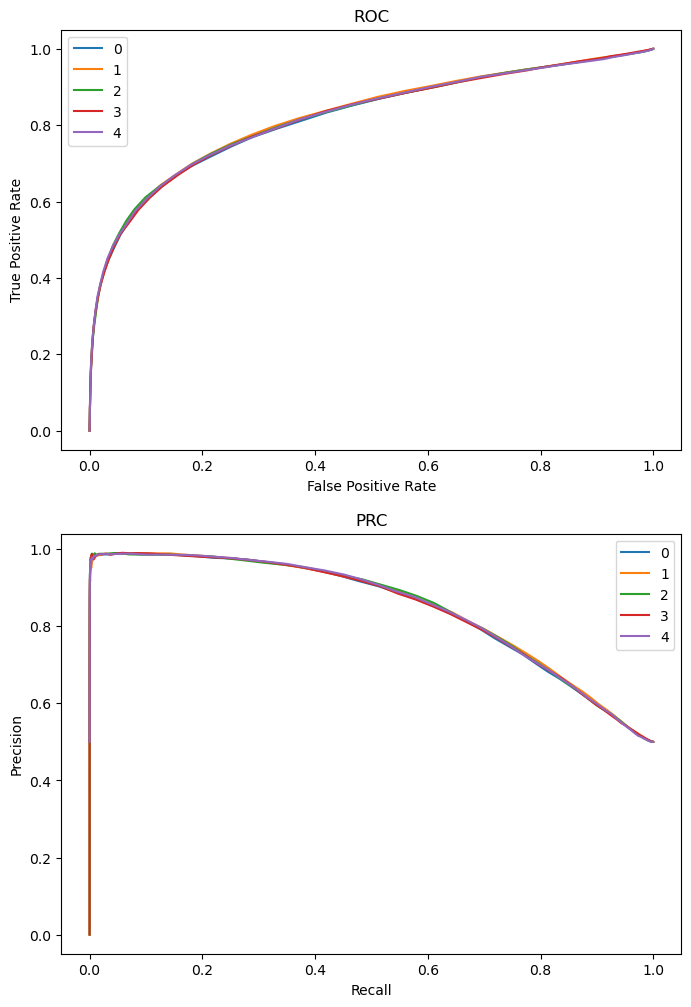

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 800x1200 with 0 Axes>

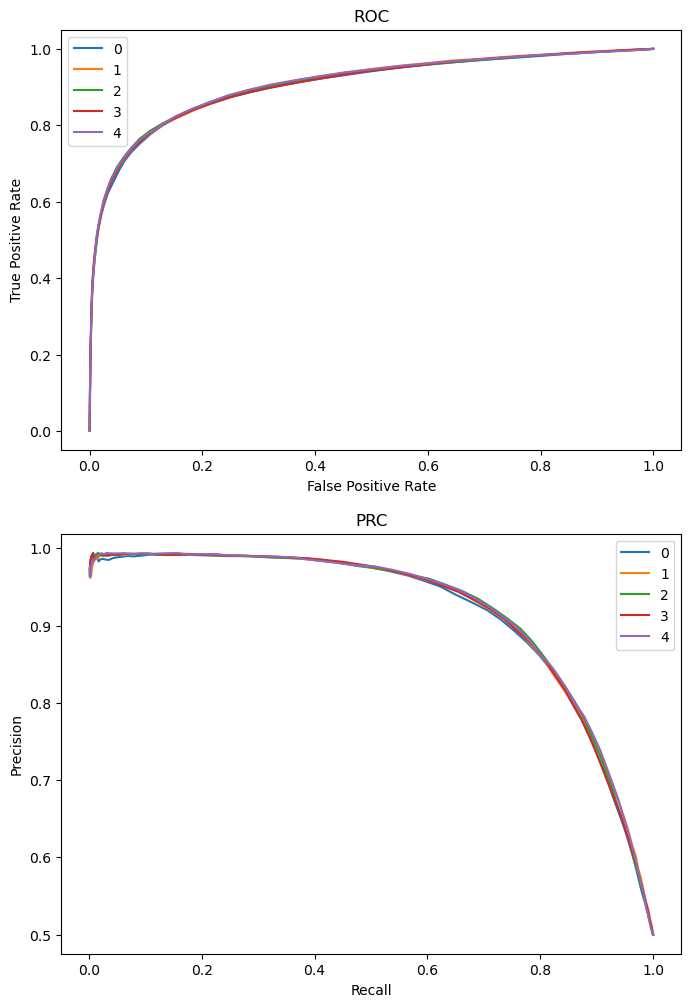

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 800x1200 with 0 Axes>

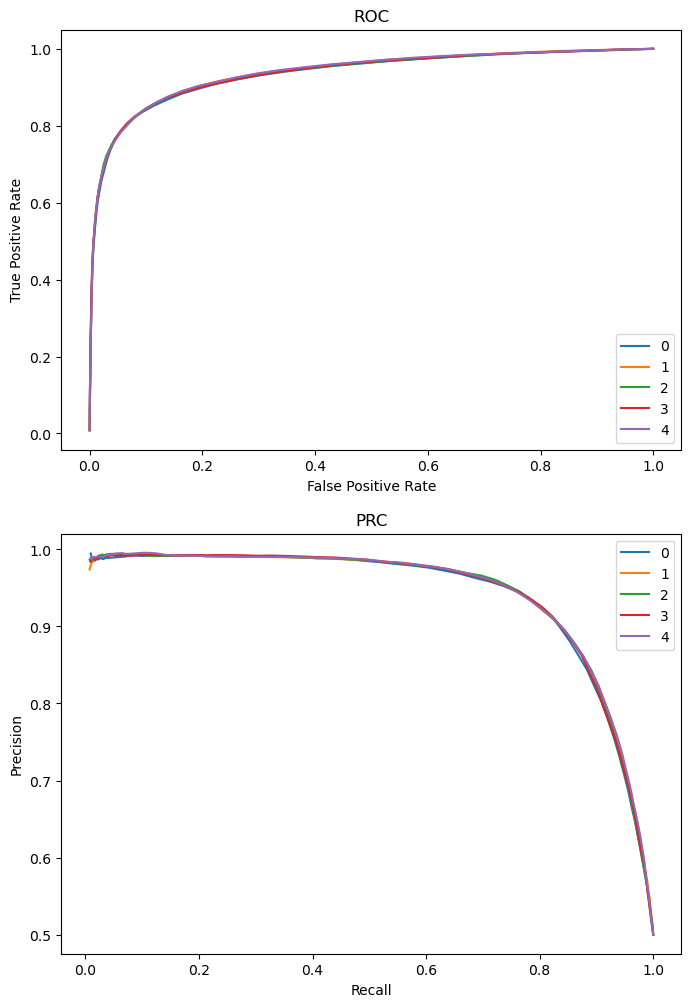

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 800x1200 with 0 Axes>

<Figure size 800x1200 with 0 Axes>

In [83]:
# if TO_OPTIMIZE_HYPERPARAMETERS:
#     optimize_order(7)
# To do multiple ROC and PRC curves for different orders
d={}
for i in tqdm(range(0,12)):
    start=time.time()
    avg_auc = plot_multiple_ROCs_and_get_avgAUC(order_loc=i)
    d[i]=avg_auc
    
    print(f'Order = {i} done. Time taken = {time.time()-start}')
    print('-----------------------------------')

with open('./results/AUC_vs_Order.txt','a') as f:
    f.write(str(d))

The above plot shows that 5 is the optimum order of the model. We retrain the model with order 5 and save it.

In [94]:
for i in range(0,11):
    ORDER = i
    mm_neg = MarkovModelMaker(ORDER,database_neg)
    mm_pos = MarkovModelMaker(ORDER,database_pos)
    mm_neg.make_model()
    mm_pos.make_model()
    mm_neg.save_model(f'./models/model_neg_order_{ORDER}.pkl')
    mm_pos.save_model(f'./models/model_pos_order_{ORDER}.pkl')
# NVS,PVS = check_test_set_scores_only(model_neg=mm_neg,model_pos=mm_pos,database_neg=database_neg,database_pos=database_pos)

AUC Of the ROC =  0.9358673723500002
Thresholds considered =  [-10.0, -9.8, -9.6, -9.4, -9.2, -9.0, -8.8, -8.6, -8.4, -8.2, -8.0, -7.8, -7.6, -7.4, -7.2, -7.0, -6.8, -6.6, -6.4, -6.2, -6.0, -5.8, -5.6, -5.4, -5.2, -5.0, -4.8, -4.6, -4.4, -4.2, -4.0, -3.8, -3.5999999999999996, -3.4000000000000004, -3.2, -3.0, -2.8, -2.5999999999999996, -2.4000000000000004, -2.2, -2.0, -1.8000000000000007, -1.5999999999999996, -1.4000000000000004, -1.1999999999999993, -1.0, -0.8000000000000007, -0.5999999999999996, -0.40000000000000036, -0.1999999999999993, 0.0, 0.1999999999999993, 0.40000000000000036, 0.5999999999999996, 0.8000000000000007, 1.0, 1.1999999999999993, 1.4000000000000004, 1.5999999999999996, 1.8000000000000007, 2.0, 2.1999999999999993, 2.4000000000000004, 2.5999999999999996, 2.8000000000000007, 3.0, 3.1999999999999993, 3.4000000000000004, 3.5999999999999996, 3.8000000000000007, 4.0, 4.199999999999999, 4.4, 4.6, 4.800000000000001, 5.0, 5.199999999999999, 5.4, 5.6, 5.800000000000001, 6.0, 6.1

<Figure size 400x400 with 0 Axes>

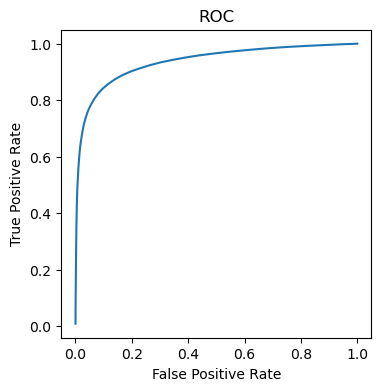

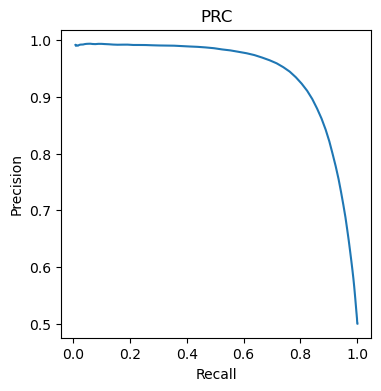

<Figure size 400x400 with 0 Axes>

In [93]:

auc = calc_AUC(NVS_roc=NVS,PVS_roc=PVS)
print('AUC Of the ROC = ',auc)
get_ROC(label='ROC',NVS_roc=NVS,PVS_roc=PVS)
plt.savefig('./results/ROC_FD.png')
get_PRC(label='PRC',NVS_roc=NVS,PVS_roc=PVS)
plt.savefig('./results/PRC_FD.png')
print('Best threshold as per the ROC is = ' , get_best_thresh(NVS_roc=NVS,PVS_roc=PVS))

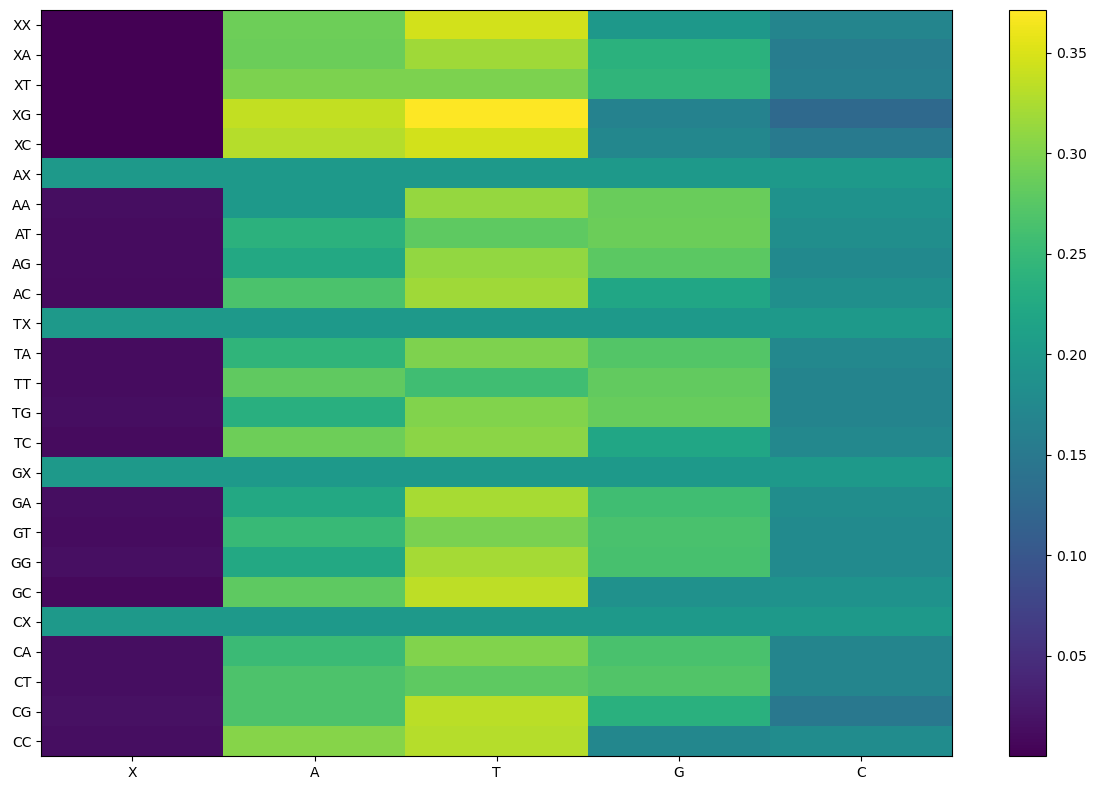

In [25]:
mm_neg.show_model_image()

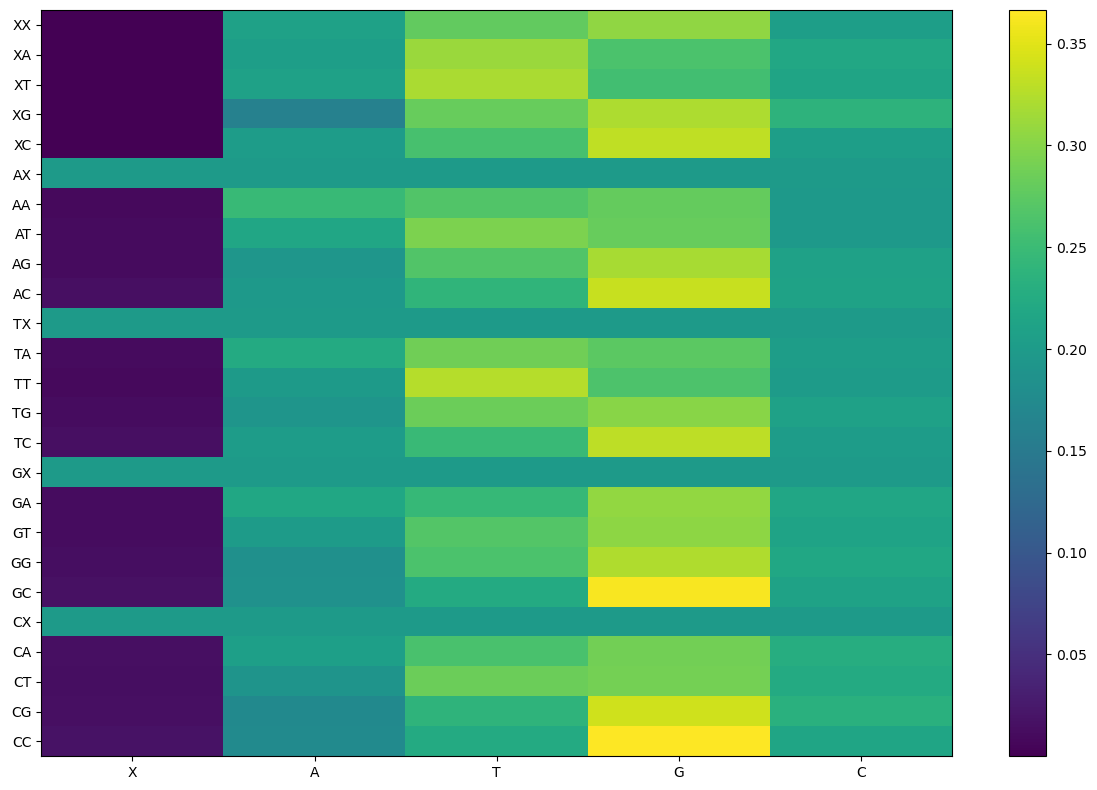

In [26]:
mm_pos.show_model_image()

In [27]:
mm_neg.save_model('./models/mm_neg_o2_FD.pkl')
mm_pos.save_model('./models/mm_pos_o2_FD.pkl')

In [28]:
end_time = time.time()
print('Time taken to execute = ', end_time-start_time)

Time taken to execute =  16729.138959884644
